In [197]:
import torch
import torch_geometric as pyg
import torch.nn as nn
import torch_geometric.nn as gnn
from torch_geometric.datasets import Planetoid, Amazon
from torch_geometric.utils import train_test_split_edges, add_self_loops, negative_sampling
from torch_geometric.transforms import RandomLinkSplit, RandomNodeSplit
import torch.optim as optim
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from loaders import Loader, LoaderInductive, LoaderTransductive, Element

In [198]:
dataset = Planetoid('cora', 'CORA')
data = dataset[0]

c:\Users\szige\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) 

In [199]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [200]:
loader : Loader = LoaderInductive(data)

In [201]:
class GINLayer(gnn.MessagePassing):
    def __init__(self, in_features: int, hidden_features: int, out_features: int, dropout: float):
        super(GINLayer, self).__init__(aggr='add')
        self.mlp_f = nn.Sequential(
            nn.Linear(in_features, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, hidden_features)
        )
        self.mlp_o = nn.Sequential(
            nn.Linear(hidden_features, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, out_features)
        )
        self.eps = nn.Parameter(torch.rand(size=(1,)))
        self.skip = nn.Linear(hidden_features, out_features)
        self.norm = nn.LayerNorm(out_features)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor):
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.shape[0])
        out = self.propagate(edge_index=edge_index, x=x) # (num_nodes, hidden_features)
        skip_out = out
        eps = (1 + self.eps)
        out = eps * self.mlp_f(x) + out
        out = self.mlp_o(out) + self.skip(skip_out) # (num_nodes, out_features)
        out = self.dropout(out)
        out = self.norm(out)
        return out # (num_nodes, out_features)

    def message(self, x_j: torch.Tensor):
        return self.mlp_f(x_j) # (num_nodes, hidden_features)


In [202]:
class MyGNN(nn.Module):
    def __init__(self, in_features: int, hidden_features: int, out_features: int, num_layers: int, dropout: float):
        super(MyGNN, self).__init__()
        self.dropout = dropout
        self.layers = nn.ModuleList([])
        self.layers.append(GINLayer(in_features, hidden_features, hidden_features, self.dropout))
        for _ in range(num_layers - 1):
            self.layers.append(GINLayer(hidden_features, hidden_features, hidden_features, self.dropout))
        self.link_predictor = nn.Sequential(
            nn.Linear(2 * hidden_features, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, out_features)        
        )
        

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor):
        for layer in self.layers:
            x = layer(x, edge_index) # (num_nodes, hidden_features)
            x = torch.relu(x)
        x_cat = self.__combine_node_embeddings(edge_index, x) # (num_nodes, 2 * hidden_features)
        x_cat = self.link_predictor(x_cat) # (num_nodes, out_features)
        return x_cat
    
    def __combine_node_embeddings(self, edges: torch.Tensor, nodes: torch.Tensor):
        return torch.cat([nodes[edges[0]], nodes[edges[1]]], dim=-1) # (num_nodes, 2 * hidden_features)

In [203]:
in_features = data.x.shape[-1]
hidden_features = 32
out_features = 1
num_layers = 10
dropout = 0.2
model = MyGNN(in_features, hidden_features, out_features, num_layers=num_layers, dropout=dropout)

In [204]:
class Trainer(ABC):
    def __init__(self, model: nn.Module, optimizer, loader: Loader):
        self.optimizer = optimizer
        self.loader = loader
        self.model = model
        self.train_loss_hist = []
        self.val_loss_hist = []
        self.val_acc_hist = []

    @abstractmethod
    def forward(self, element: Element):
        pass

    @abstractmethod
    def get_loss(self, element: Element) -> torch.Tensor:
        pass

    @abstractmethod
    def get_acc(self, element: Element) -> torch.Tensor:
        pass

    
    def train(self, num_epochs: int, patience: int):
        patience_counter = 0
        best_model_wts = None
        best_loss = torch.inf
        self.train_loss_hist = []
        self.val_loss_hist = []
        self.val_acc_hist = []
        for epoch in range(num_epochs):
            model.train()
            self.optimizer.zero_grad()
            loss = self.get_loss(self.loader.train_data)
            loss.backward()
            train_loss = loss.item()
            self.train_loss_hist.append(train_loss)
            self.optimizer.step()
            model.eval()
            with torch.inference_mode():
                val_loss = self.get_loss(self.loader.val_data).item()
                val_acc = self.get_acc(self.loader.val_data).item()
                self.val_loss_hist.append(val_loss)
                self.val_acc_hist.append(val_acc)
                if val_loss < best_loss:
                    best_loss = val_loss
                    patience_counter = 0
                    best_model_wts = model.state_dict()
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print('Early stop')
                        break
            print(f'Epoch: {epoch + 1} | Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f} | Val accuracy: {val_acc:.3f}')
        model.load_state_dict(best_model_wts)

    def plot_train_history(self):
        fig, axes = plt.subplots(1, 2, figsize=(16,8))
        axes[0].plot(self.train_loss_hist, label='Train loss')
        axes[0].plot(self.val_loss_hist, label='Validation loss')
        axes[0].set_xlabel('Epochs')
        axes[0].set_ylabel('Loss')
        axes[0].legend()
        axes[0].set_title('Losses')
        axes[0].grid()
        axes[1].plot(self.val_acc_hist, label='Validation accuracy')
        axes[1].set_xlabel('Epochs')
        axes[1].set_ylabel('Accuracy')
        axes[1].legend()
        axes[1].set_title('Accuracy')
        axes[1].grid()
        fig.suptitle('Metrics during training')
        plt.show()

    @abstractmethod
    def evaluate_test_set(self):
        pass


class A(Trainer):
    def __init__(self, model, optimizer, loader):
        super().__init__(model, optimizer, loader)

    def __to_cat(self, arr: torch.Tensor):
        return torch.round(torch.sigmoid(arr))
    
    def get_loss(self, element):
        pos_scores, neg_scores = self.forward(element)
        pos_scores = torch.sigmoid(pos_scores)
        neg_scores = torch.sigmoid(neg_scores)
        return -torch.mean(torch.log(pos_scores) + torch.log(1 - neg_scores))
    
    def get_acc(self, element):
        pos_scores, neg_scores = self.forward(element)
        pos_scores = self.__to_cat(pos_scores)
        neg_scores = self.__to_cat(neg_scores)
        n = pos_scores.shape[0] + neg_scores.shape[0]
        return (torch.sum(pos_scores == 1) + torch.sum(neg_scores == 0)) / n
    
    def forward(self, element):
        pos_scores = model(element.x, element.edge_index)
        neg_scores = model(element.x, element.neg_edge_index)
        return pos_scores, neg_scores
    
    def evaluate_test_set(self):
        test_pos_scores, test_neg_scores = self.forward(loader.test_data)
        test_pos_scores, test_neg_scores = test_pos_scores.detach(), test_neg_scores.detach()
        test_pos_scores = self.__to_cat(test_pos_scores)
        test_neg_scores = self.__to_cat(test_neg_scores)
        labels_pos = torch.ones_like(test_pos_scores)
        labels_neg = torch.zeros_like(test_neg_scores)
        labels = torch.cat([labels_pos, labels_neg])
        logits = torch.cat([test_pos_scores, test_neg_scores])
        sns.heatmap(confusion_matrix(labels, logits), annot=True, cmap='Blues')
        plt.xticks([0.5,1.5], ['Negative', 'Positive'])
        plt.yticks([0.5,1.5], ['Negative', 'Positive'])
        plt.xlabel('Prediction')
        plt.ylabel('True')
        plt.show()

In [205]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
trainer: Trainer = A(model, optimizer, loader)
trainer.train(100, 5)

Epoch: 1 | Loss: 1.394 | Val Loss: 1.342 | Val accuracy: 0.881
Epoch: 2 | Loss: 1.366 | Val Loss: 1.310 | Val accuracy: 0.872
Epoch: 3 | Loss: 1.363 | Val Loss: 1.290 | Val accuracy: 0.865
Epoch: 4 | Loss: 1.337 | Val Loss: 1.236 | Val accuracy: 0.854
Epoch: 5 | Loss: 1.299 | Val Loss: 1.264 | Val accuracy: 0.754
Epoch: 6 | Loss: 1.278 | Val Loss: 1.158 | Val accuracy: 0.868
Epoch: 7 | Loss: 1.216 | Val Loss: 1.108 | Val accuracy: 0.868
Epoch: 8 | Loss: 1.147 | Val Loss: 1.163 | Val accuracy: 0.791
Epoch: 9 | Loss: 1.121 | Val Loss: 1.053 | Val accuracy: 0.868
Epoch: 10 | Loss: 1.053 | Val Loss: 0.880 | Val accuracy: 0.991
Epoch: 11 | Loss: 1.017 | Val Loss: 1.016 | Val accuracy: 0.856
Epoch: 12 | Loss: 0.981 | Val Loss: 0.993 | Val accuracy: 0.856
Epoch: 13 | Loss: 0.954 | Val Loss: 0.941 | Val accuracy: 0.876
Epoch: 14 | Loss: 0.881 | Val Loss: 0.707 | Val accuracy: 0.997
Epoch: 15 | Loss: 0.875 | Val Loss: 0.919 | Val accuracy: 0.868
Epoch: 16 | Loss: 0.827 | Val Loss: 0.904 | Val a

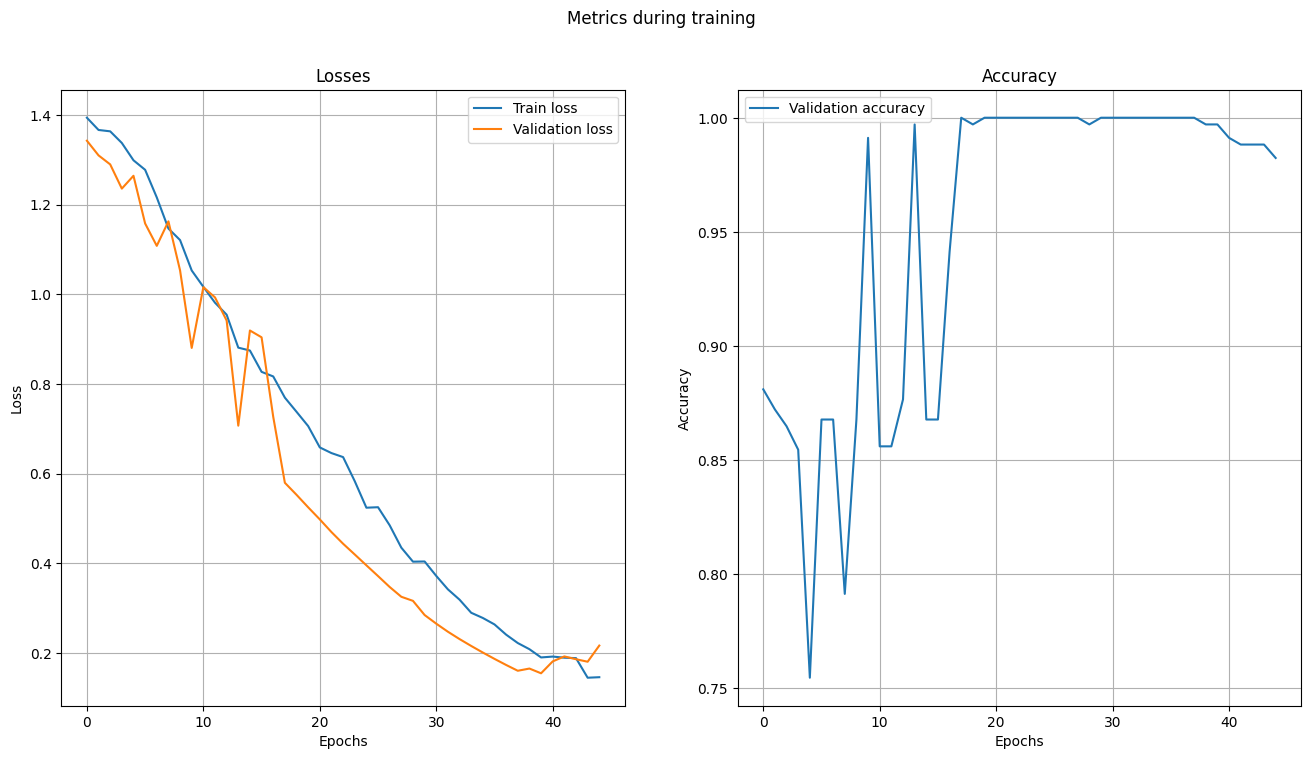

In [206]:
trainer.plot_train_history()

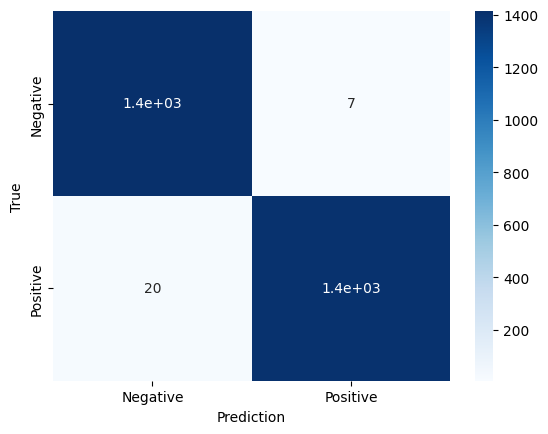

In [207]:
trainer.evaluate_test_set()